# Water mass transformation analysis development notebook

This notebook is the analysis and visualization component of the `wmtf_dev.py` script

***

In [10]:
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [11]:
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Formulation

MPAS-Ocean is volume conserving, freshwater fluxes are kg FW m$^{-2}$ s$^{-1}$ and are implimented via a layer thickness state variable. The formulation used here follows the balanced diffusive salt flux described by Nurser and Griffies (2019) JPO

$$ F = \frac{1}{\rho_0}\frac{\partial\rho}{\partial T}\frac{\text{SHF}}{C_p} - \frac{1}{\rho_0}\frac{\partial\rho}{\partial S} S \bigg(\text{SFWF}\bigg)$$

where SHF (surface heat flux) and SFWF (surface freshwater flux) are positive into the ocean, $\rho_0 = 1026$ kg m$^{-3}$ and $C_p = 3.996 \times 10^3$ J kg$^{-1}$ C$^{-1}$ based on the MPAS constants.

***

### Load WMTF results

In [13]:
# Load results
ds = {}
timeslice = slice(datetime(1997, 1, 1), datetime(2006, 12, 31))
resultspath = '/pscratch/sd/b/bmoorema/results/wmtf/'
#meshes, dateranges = ['60to30E2r2', '18to6v3'], ['19470101_20091201', '19970101_20061201']
#for mesh, daterange in zip(meshes, dateranges):
mesh, daterange = '60to30E2r2', '19470101_20091201'
filename = f'20210421_sim7_CORE_{mesh}.watermasses_{daterange}.nc'
ds[mesh] = xr.open_dataset(resultspath + filename).sel(time=timeslice)

# Define indices
time = ds['60to30E2r2'].time.values.astype('datetime64[s]').astype(datetime)
sigma = ds['60to30E2r2'].sigmabins.values

#-np.diff(wmtf[name][0, ...], axis=2, append=0)

***

### Results Overview (North Atlantic subbasin)

   1. TR curves in the MPAS runs are smaller than the curves for POP by about 5 Sv
   2. The heat flux contribution dominates the TR curves everywhere
   3. STMW and SPMW are both present in FR curces at low-res
   3. SPMW is more pronounced in the high-res but STMW formation nearly vanishes

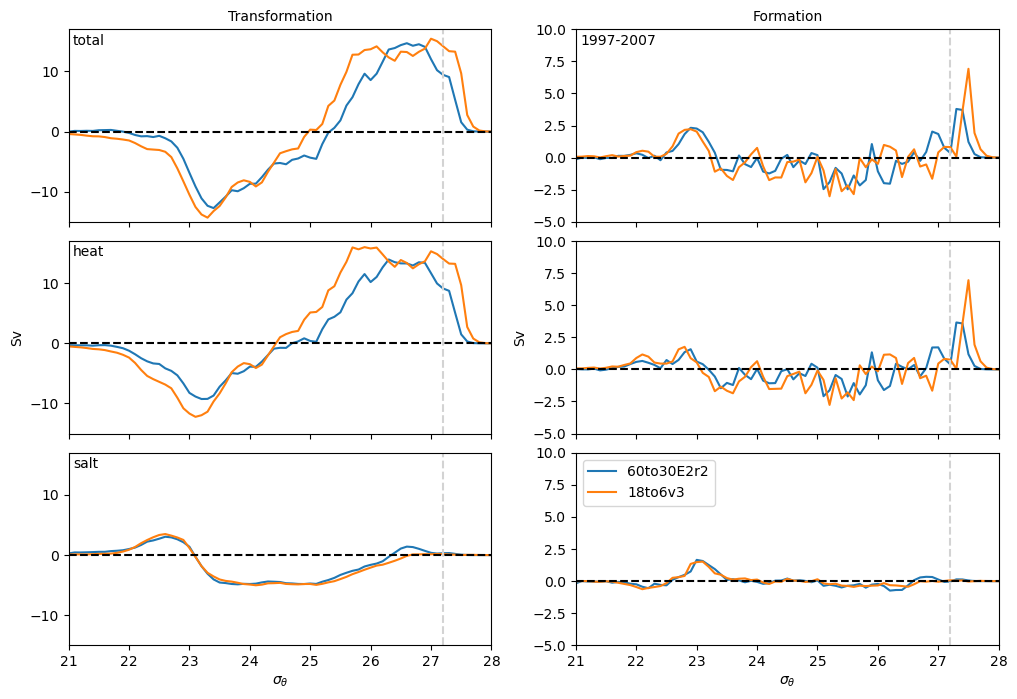

In [27]:
# North Atlantic Region
region = 'North Atlantic Ocean'

# Make plot area
fig, axs = plt.subplots(3, 2, figsize=(12, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.2})
xlim = [21, 28]

# Plot meshes
ctgys, titles, ylims = ['tr', 'fm'], ['Transformation', 'Formation'], [(-15, 17), (-5, 10)]
for col, ctgy, title, ylim in zip(axs.T, ctgys, titles, ylims):
    
    col[0].set_title(title)
    col[1].set_ylabel('Sv')
    col[2].set_xlabel('$\\sigma_{\\theta}$')
    
    # Plot components
    for ax, name in zip(col, ['total', 'heat', 'salt']):

        # Plot region 10-year averages
        for mesh in meshes:
            y = ds[mesh][ctgy][name].sel(regions=region).mean(dim='time')
            ax.plot(sigma, y, label=mesh)
        
        # Formatting
        ax.plot(xlim, [0, 0], 'k--')
        ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if name != 'salt':
            ax.xaxis.set_ticklabels('')
        if ctgy == 'tr':
            ax.text(0.01, 0.92, name, transform=ax.transAxes)
        

# More formatting
axs[0, 1].text(0.01, 0.92, '1997-2007', transform=axs[0, 1].transAxes)
axs[2, 1].legend(loc=2)
plt.show()

***

### Total Formation: regional breakdown

Five subregions dominate STMW and SPMW formation in the forced low-res and high-res runs.

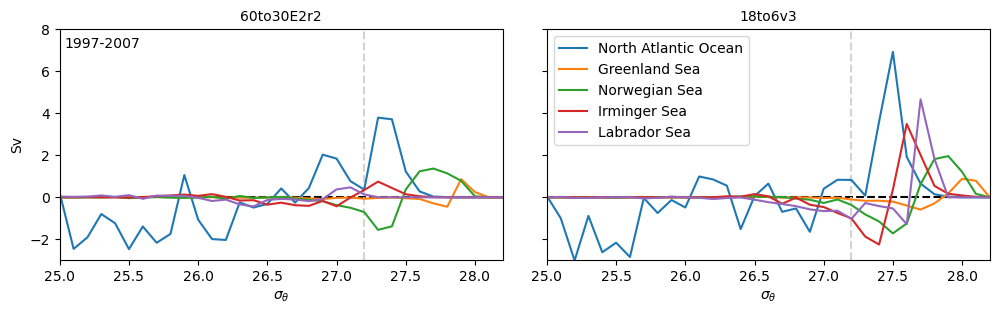

In [40]:
# NA mode water regions
regions = [
    'North Atlantic Ocean',
    'Greenland Sea',
    'Norwegian Sea',
    'Irminger Sea',
    'Labrador Sea',
]

# Make plot area
fig, axs = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim, ylim = [25, 28.2], [-3, 8]

# Plot meshes
for ax, mesh in zip(axs.T, meshes):
    
    # Formatting
    ax.plot(xlim, [0, 0], 'k--')
    ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$\\sigma_{\\theta}$')
    ax.set_title(mesh)

    # Plot region 10-year averages
    for region in regions:
        y = ds[mesh]['fm'].total.sel(regions=region).mean(dim='time')
        ax.plot(sigma, y, label=region)

# More formatting
axs[0].text(0.01, 0.92, '1997-2007', transform=axs[0].transAxes)
axs[0].set_ylabel('Sv')
axs[1].yaxis.set_ticklabels('')
axs[1].legend(loc=2)
plt.show()

***

### Formation time variability (North Atlantic subbasin)

   1. Formation is concentrated in the winter
   2. Formation at 26.5 to 27.2 is persistently higher in low-res

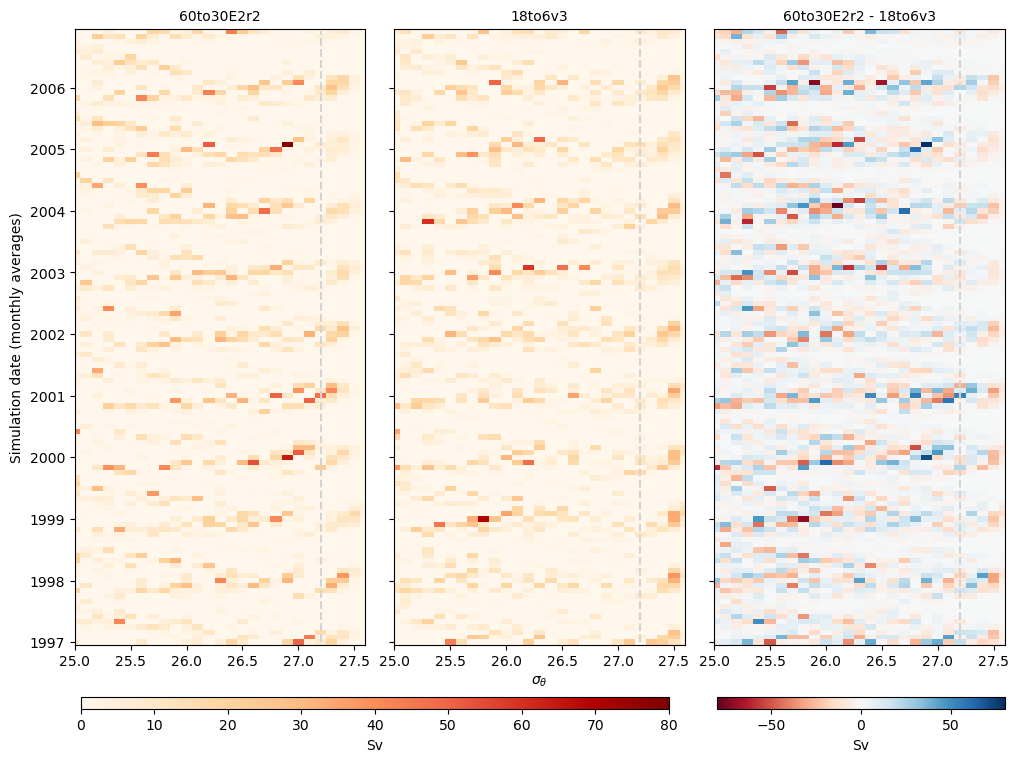

In [41]:
# North Atlantic Region
region = 'North Atlantic Ocean'

# Make plot area
fig, axs = plt.subplots(1, 3, figsize=(12, 8), gridspec_kw={'wspace': 0.1})
xlim, ylim = [25, 27.6], time[[0, -1]]

# Plot meshes
for ax, mesh in zip(axs[:2], meshes):
    ax.set_title(mesh)
    z = ds[mesh]['fm'].total.sel(regions=region)
    c1 = ax.pcolormesh(sigma, time, z, cmap='OrRd', vmin=0, vmax=80)

# Plot difference
z = np.subtract(*[ds[mesh]['fm'].total.sel(regions=region) for mesh in meshes])
c2 = axs[2].pcolormesh(sigma, time, z, cmap='RdBu', vmin=-80, vmax=80)
axs[2].set_title(' - '.join(meshes))

# Format axes
axs[0].set_ylabel('Simulation date (monthly averages)')
axs[1].set_xlabel('$\\sigma_{\\theta}$')
for ax in axs:
    ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
    ax.set_xlim(xlim)
for ax in axs[1:]: ax.yaxis.set_ticklabels('')

# Add colorbars
cax1 = fig.add_axes([0.13, 0.03, 0.49, 0.015])
cax2 = fig.add_axes([0.66, 0.03, 0.24, 0.015])
fig.colorbar(c1, cax=cax1, label='Sv', orientation='horizontal')
fig.colorbar(c2, cax=cax2, label='Sv', orientation='horizontal')

plt.show()

***

### Formation (winter only)

   1. Formation rates increase by a factor of about three
   2. STMW formation becomes more prevalent in both low-res and high-res

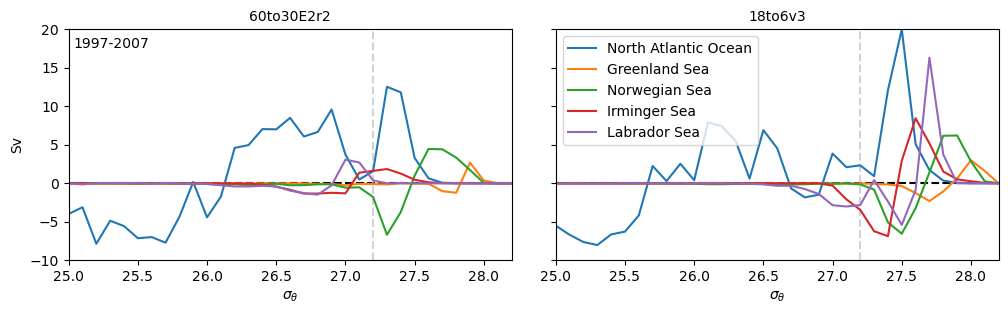

In [55]:
# NA mode water regions
regions = [
    'North Atlantic Ocean',
    'Greenland Sea',
    'Norwegian Sea',
    'Irminger Sea',
    'Labrador Sea',
]

# DJF index
time_djf = time[[t.month in [12, 1, 2] for t in time]]

# Make plot area
fig, axs = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim, ylim = [25, 28.2], [-10, 20]

# Plot meshes
for ax, mesh in zip(axs.T, meshes):
    
    # Formatting
    ax.plot(xlim, [0, 0], 'k--')
    ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$\\sigma_{\\theta}$')
    ax.set_title(mesh)

    # Plot region 10-year averages
    for region in regions:
        y = ds[mesh]['fm'].total.sel(time=time_djf, regions=region).mean(dim='time')
        ax.plot(sigma, y, label=region)

# More formatting
axs[0].text(0.01, 0.92, '1997-2007', transform=axs[0].transAxes)
axs[0].set_ylabel('Sv')
axs[1].yaxis.set_ticklabels('')
axs[1].legend(loc=2)
plt.show()